In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

SEAS = ['APCOMP', 'APMTH', 'APPHY', 'BE', 'COMPSCI', 'ENG-SCI', 'ESE']
GENED = ['GENED']
SCIENCES = ['VIROLOGY', 'QSE', 'SCIENCE', 'CELLBIO', 'STAT', 'MED-SCI', 'LIFESCI', 'BMIF', 'MCB', 'DRB', 'MICROBI', 'NEUROBIO', 'HEB', 'CPB', 'IMMUN', 'HBTM', 'BBS', 'OEB', 'GENETIC', 'ASTRON', 'SYSBIO', 'SHBT', 'NEURO', 'LPS', 'PHYSCI', 'SCRB', 'BIOPHYS', 'MATH', 'BCMP', 'CHEM', 'PHYSICS', 'BIOSTAT', 'E-PSCI']
SOCIAL_SCIENCES = ['OROMO', 'AFRIKAAN', 'ECON', 'GHHP', 'HISTSCI', 'HLTHPOL', 'ESPP', 'WSTAFRCN', 'WOMGEN', 'IGBO', 'BPH', 'SOCIOL', 'GOV', 'AMHARIC', 'YORUBA', 'ANTHRO', 'AFRAMER', 'HIST', 'MBB', 'PHS', 'AAAS', 'EMR', 'PSY', 'SOC-STD']
ARTS_HUMANITIES = ['AFVS', 'AKKAD', 'ALBANIAN', 'HUMAN', 'MUSIC', 'ARABIC', 'SWEDISH', 'CHNSE', 'ISLAMCIV', 'EASTD', 'SLAVIC', 'ANE', 'FRENCH', 'TDM', 'SPANSH', 'CLS-STDY', 'RSRA', 'CHNSHIS', 'TIBET', 'GERMAN', 'NEC', 'MEDLATIN', 'SWAHILI', 'RELIGION', 'JAPAN', 'YIDDISH', 'FOLKMYTH', 'RUSS', 'SANSKRIT', 'SAS', 'LING', 'GREEK', 'ITAL', 'MODGRK', 'ZULU', 'KOREAN', 'JAMAICAN', 'PERSIAN', 'CHNSLIT', 'SCAND', 'JAPNLIT', 'LATIN', 'MODMDEST', 'TURKISH', 'JAPNHIST', 'FT', 'MOD-HEB', 'CLASPHIL', 'ENGLISH', 'KORHIST', 'ROM-STD', 'PHIL', 'PORTUG', 'HIST-LIT', 'COMPLIT', 'MEDVLSTD', 'HIND-URD', 'EAFM', 'UKRA', 'CELTIC', 'TS', 'HAA', 'RSEA', 'HAITIAN', 'VIETNAM', 'TAM', 'BCS']
ADDITIONAL = ['EXPOS', 'EDST', 'CE', 'FYSEMR']

def number_of_classifiers(raw_list):
        '''
        Given a list of comments as a string, return the number of classifiers in the list.

        A classifier is defined as a comment that is either:
        1. A comment that starts with a '*' character
        2. A comment that contains the word 'gem' or 'gemmy' and does not contain the words 'not a gem' or 'not gemmy'
        '''
        lst = eval(raw_list)

        classifiers = 0

        for entry in lst:
            # check if entry is a classifier
            # if '*' is the first character, then it is a classifier
            entry = entry.lower().strip()
            if entry[0] == '*':
                classifiers += 1
                continue

            # if 'gem' or 'gemmy' is in the entry, AND 'not a gem' and 'not gemmy' are not in the entry, then it is a classifier
            if ('gem' in entry or 'gemmy' in entry) and ('not a gem' not in entry and 'not gemmy' not in entry):
                classifiers += 1

        return classifiers

In [12]:
def import_dfs(main_path: str, comment_path: str, instructor_path: str):
    '''
    Given paths to the courses, comments, and instructors csv files, import the dataframes and return them.
    This function also assigns:
    - number of comments to each course
    - gem classifiers to each course
    - category to each course
    - gem_index to each course

    '''

    df = pd.read_csv(main_path)
    df_comments = pd.read_csv(comment_path)
    df_instructors = pd.read_csv(instructor_path)

    df['hours'] = np.where((df['hours'] < 0), np.nan, df['hours'])

    number_of_comments = []
    for comment in df['comments'].values:
        number_of_comments.append(len(eval(comment)))

    df['number_of_comments'] = number_of_comments
    df['gem_classifiers'] = df['comments'].apply(number_of_classifiers)
    
    # set each class to a category
    df['category'] = df['department'].apply(lambda x: 'SEAS' if x in SEAS else ('GENED' if x in GENED else ('SCIENCES' if x in SCIENCES else ('SOCIAL_SCIENCES' if x in SOCIAL_SCIENCES else ('ARTS_HUMANITIES' if x in ARTS_HUMANITIES else ('ADDITIONAL' if x in ADDITIONAL else 'OTHER'))))))

    # get gem_index
    res = []
    for i in range(len(df)):
        curr_entry = df.iloc[i]

        department_df = df[df['department'] == curr_entry['department']]

        instructors_in_department = df_instructors[df_instructors['course_id'].isin(department_df['course_id'])]

        z_score_students_department = (curr_entry['students'] - np.mean(department_df['students'])) / np.std(department_df['students'])

        z_score_recommendations_department = (curr_entry['recommendations'] - np.mean(department_df['recommendations'])) / np.std(department_df['recommendations'])

        # take the minimum of all instructors of the course

        min_instructor = np.min(df_instructors[df_instructors['course_id'] == curr_entry['course_id']]['instructor_rating'])

        z_score_instructor_rating_department = (min_instructor - np.mean(instructors_in_department['instructor_rating'])) / np.std(instructors_in_department['instructor_rating'])

        res.append(
            (5 - curr_entry['hours']) + 10 * (curr_entry['avg_sentiment'] * curr_entry['gem_classifiers']/curr_entry['number_of_comments']) + min(z_score_students_department, 3) + min(z_score_recommendations_department, 0.5) + min(z_score_instructor_rating_department, 0.5)
        )

    df['gem_index'] = res

    if 'pros' not in df.columns:
        df['pros'] = ''
        df['cons'] = ''
        df['feedback'] = ''

    return df, df_comments, df_instructors

# Creating Merged Database

In [13]:
df_2023_2024, df_comments_2023_2024, df_instructors_2023_2024 = import_dfs('qreport_app/working_data/courses_2023_2024.csv', 'qreport_app/working_data/comments_2023_2024.csv', 'qreport_app/working_data/instructors_2023_2024.csv')

df_2022_2023, df_comments_2022_2023, df_instructors_2022_2023 = import_dfs('qreport_app/working_data/courses_2022_2023.csv', 'qreport_app/working_data/comments_2022_2023.csv', 'qreport_app/working_data/instructors_2022_2023.csv')

df_2021_2022, df_comments_2021_2022, df_instructors_2021_2022 = import_dfs('qreport_app/working_data/courses_2021_2022.csv', 'qreport_app/working_data/comments_2021_2022.csv', 'qreport_app/working_data/instructors_2021_2022.csv')

full_df = pd.concat([df_2023_2024, df_2022_2023, df_2021_2022])
full_comments = pd.concat([df_comments_2023_2024, df_comments_2022_2023, df_comments_2021_2022])
full_instructors = pd.concat([df_instructors_2023_2024, df_instructors_2022_2023, df_instructors_2021_2022])

full_df.to_csv('qreport_app/data/BETA_class_data.csv', index=False)
full_comments.to_csv('qreport_app/data/BETA_comments_data.csv', index=False)
full_instructors.to_csv('qreport_app/data/BETA_instructors_data.csv', index=False)

/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_95223/1543044910.py:45: RuntimeWarning: invalid value encountered in scalar divide
  z_score_instructor_rating_department = (min_instructor - np.mean(instructors_in_department['instructor_rating'])) / np.std(instructors_in_department['instructor_rating'])
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_95223/1543044910.py:37: RuntimeWarning: invalid value encountered in scalar divide
  z_score_students_department = (curr_entry['students'] - np.mean(department_df['students'])) / np.std(department_df['students'])
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_95223/1543044910.py:39: RuntimeWarning: invalid value encountered in scalar divide
  z_score_recommendations_department = (curr_entry['recommendations'] - np.mean(department_df['recommendations'])) / np.std(department_df['recommendations'])
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_95223/1543044910.py:37: RuntimeWarning: invalid value 

# Outline of things to do


### OVERALL REPORT
- Mean hours by department
- Gem index rankings
- FAS vs. SEAS distributions
- STEM vs non-STEM distributions

### SPLIT BY DEPARTMENT
- Hours distribution
- Instructor distribution
- Department word cloud (?)
- Sentiment distributions

### INDIVIDUAL CLASS
- Word cloud
- Average hours
- Predicted hours for next year
- Pros, cons, feedback
- Gem index
- Recommendations
- Sentiment distribution

# OVERALL REPORT

## Sentiment Analysis

For sentiment analysis, it would be pretty interesting to take a Bayesian approach.

First, let's lay down some assumptions. We want to determine "deviant" effects from the observed class school, department, and individual class. We assume that each school has some average sentiment on prior:

$$\xi_{s} \sim Unif(-1, 1)$$


Then, within each school, the department has some deviant effect as well. This effect should be some transformation of $$\xi_{sd} \sim N(\xi_s, \sigma_d^2)$$

From there, we observe each comment as having a sentiment value from each course. These comments can vary in ammount, but we can say that they come from a distribution from the department differed by some additive "course effect":

$$\xi_{sdi, j} \sim N(\xi_{sd}, \sigma_d^2) + N(\alpha_i, \sigma_i^2)$$

We then aim to estimate all of these parameters.

In [14]:
# RESTART

# define temporary variable df of just 2023-2024
df = df_2023_2024.copy()

# create bayesian_df which will store the data needed for the bayesian model
# also adding id's because it makes things nice for missing values
bayesian_df = df[['category', 'department', 'avg_sentiment']]
bayesian_df['course_id'] = bayesian_df.index
bayesian_df = bayesian_df.reset_index(drop=True).dropna()

# translation dictionaries for ids
department_to_id = {
    department: i for i, department in enumerate(bayesian_df['department'].unique())
}
category_to_id = {
    category: i for i, category in enumerate(bayesian_df['category'].unique())
}
course_id_to_id = {
    course_id: i for i, course_id in enumerate(bayesian_df['course_id'].unique())
}

# create id columns
bayesian_df['department_id'] = bayesian_df['department'].apply(lambda x: department_to_id[x])
bayesian_df['category_id'] = bayesian_df['category'].apply(lambda x: category_to_id[x])
bayesian_df['course_id_id'] = bayesian_df['course_id'].apply(lambda x: course_id_to_id[x])

# create a dataframe that is just unique department_ids with their corresponding category_ids
# this will be used to model the department mean given the category
department_id_df = bayesian_df[['department_id', 'category_id']].drop_duplicates()

# we observe each comment on each course
# so we have a separate observation df
observation_df = df_comments_2023_2024.copy()

# limit observation_df to only the courses that are in bayesian_df
observation_df = observation_df[observation_df['course_id'].isin(bayesian_df['course_id'])]

# add department_id and course_id_id to observation_df
department_ids = []

for i in range(len(observation_df)):
    curr_entry = observation_df.iloc[i]

    department_ids.append(department_to_id[curr_entry['department']])

observation_df['department_id'] = department_ids
observation_df['course_id_id'] = [course_id_to_id[course_id] for course_id in observation_df['course_id']]

/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_95223/4182518842.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayesian_df['course_id'] = bayesian_df.index


In [15]:
import pymc as pm
import numpy as np
import pandas as pd

# we want to model the average sentiment of a course given the department and category of a course
# each row in bayesian_df is a course, and we want to model the 'avg_sentiment' of each course given the department of the course, and the department of the course given the category of the course
# each category will have a prior of uniform(-1, 1)
# each department will be prior normal(category_mean, category_std)
# the 'avg_sentiment' of each course will be normal(department_mean, department_std) and will be observed

# we will use a hierarchical model to model the 'avg_sentiment' of each course given the department of the course
# we will use a normal prior for the department mean and a uniform prior for

with pm.Model() as model:
    # category prior
    category_mean = pm.Uniform('category_mean', lower=-1, upper=1, shape=len(bayesian_df['category_id'].unique()))

    # department prior
    department_std = pm.InverseGamma('department_std', alpha=2, beta=1)
    department_mean = pm.Normal('department_mean', mu=category_mean[department_id_df['category_id']], sigma=department_std, shape=len(department_id_df))

    # likelihood
    additive_effect = pm.Normal('additive_effect', mu=0, sigma=1, shape=len(bayesian_df))
    likelihood_sd = pm.InverseGamma('likelihood_sd', alpha=2, beta=1)
    likelihood = pm.Normal('likelihood', mu=department_mean[observation_df['department_id']] + additive_effect[observation_df['course_id_id']], sigma=likelihood_sd, observed=observation_df['sentiment'])

    trace = pm.sample(2000, step=[pm.NUTS(target_accept=0.99,max_treedepth=40)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [category_mean, department_std, department_mean, additive_effect, likelihood_sd]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


1.41


KeyboardInterrupt: 

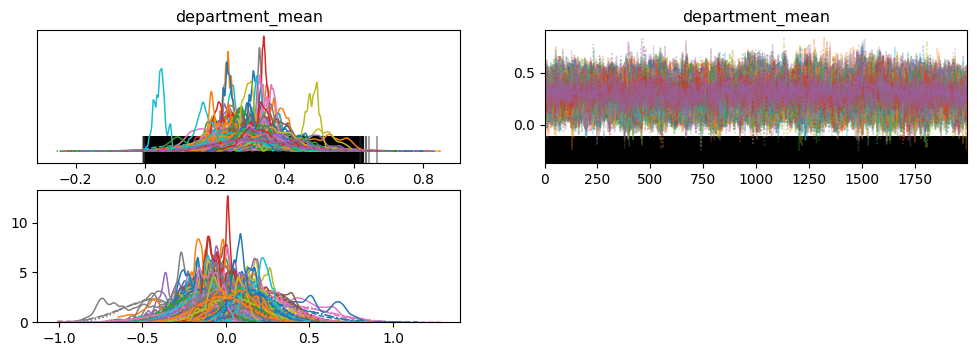

In [38]:
# check r_hat and plot
import arviz as az
print(pm.summary(trace)['r_hat'].max())

az.plot_trace(trace)
plt.title('Trace Plot')
plt.tight_layout()
plt.show()

In [16]:
# save 500 samples of each strace
# have the key be department, category, and course_id
distribution_samples = {}

for i in range(len(department_to_id)):
    department = list(department_to_id.keys())[i]
    distribution_samples[department] = np.array(trace['posterior']['department_mean'][0, :500, i])

for i in range(len(category_to_id)):
    category = list(category_to_id.keys())[i]
    distribution_samples[category] = np.array(trace['posterior']['category_mean'][0, :500, i])

for i in range(len(course_id_to_id)):
    course_id = list(course_id_to_id.keys())[i]
    distribution_samples[course_id] = np.array(trace['posterior']['additive_effect'][0, :500, i])

# save distribution_samples to a pickle file
import pickle

with open('qreport_app/data/distribution_samples.pkl', 'wb') as f:
    pickle.dump(distribution_samples, f)

# Multiple Instructors

For this section, we want to concat all previous years into one. Each class has a unique *course_id*, so each table is connected on that.

The issue is that we want to capture courses over time, assuming similar syllabi. So, we can assign course id's based on *easy_name*.

In [17]:
df_2023_2024 = pd.read_csv('qreport_app/working_data/courses_2023_2024.csv')
df_comments_2023_2024 = pd.read_csv('qreport_app/working_data/comments_2023_2024.csv')
df_instructors_2023_2024 = pd.read_csv('qreport_app/working_data/instructors_2023_2024.csv')

df_2022_2023 = pd.read_csv('qreport_app/working_data/courses_2022_2023.csv')
df_comments_2022_2023 = pd.read_csv('qreport_app/working_data/comments_2022_2023.csv')
df_instructors_2022_2023 = pd.read_csv('qreport_app/working_data/instructors_2022_2023.csv')

df_2021_2022 = pd.read_csv('qreport_app/working_data/courses_2021_2022.csv')
df_comments_2021_2022 = pd.read_csv('qreport_app/working_data/comments_2021_2022.csv')
df_instructors_2021_2022 = pd.read_csv('qreport_app/working_data/instructors_2021_2022.csv')

full_df = pd.concat([df_2021_2022, df_2022_2023, df_2023_2024]).drop('Unnamed: 0', axis=1)
full_comments = pd.concat([df_comments_2021_2022, df_comments_2022_2023, df_comments_2023_2024])
full_instructors = pd.concat([df_instructors_2021_2022, df_instructors_2022_2023, df_instructors_2023_2024])

full_df['category'] = full_df['department'].apply(lambda x: 'SEAS' if x in SEAS else ('GENED' if x in GENED else ('SCIENCES' if x in SCIENCES else ('SOCIAL_SCIENCES' if x in SOCIAL_SCIENCES else ('ARTS_HUMANITIES' if x in ARTS_HUMANITIES else ('ADDITIONAL' if x in ADDITIONAL else 'OTHER'))))))

In [18]:
full_df = full_df[['department', 'category', 'easy_name', 'course_id', 'hours']].dropna()
full_instructors = full_instructors.dropna()

full_instructors = full_instructors[full_instructors['course_id'].isin(full_df['course_id'])]

In [19]:
# create ids for each easy name
easy_name_to_ids = {
    name : i for i, name in enumerate(full_df['easy_name'].unique())
}

ids_to_easy_name = {v : k for k, v in easy_name_to_ids.items()}

# create ids for instructors
instructor_to_ids = {
    name : i for i, name in enumerate(full_instructors['instructor'].unique())
}

ids_to_instructor = {v : k for k, v in instructor_to_ids.items()}

# now, we need to add the easy_names and course ids to full_instructors
def get_easy_name_from_id(course_id: int) -> str:
    return full_df[full_df['course_id'] == course_id]['easy_name'].values[0]

def get_department_id_from_id(course_id: int) -> int:
    return full_df[full_df['course_id'] == course_id]['department_id'].values[0]

def get_hours_from_id(course_id: int) -> float:
    return full_df[full_df['course_id'] == course_id]['hours'].values[0]

full_instructors['easy_name'] = full_instructors['course_id'].apply(get_easy_name_from_id)
full_instructors['easy_name_id'] = full_instructors['easy_name'].apply(lambda x: easy_name_to_ids[x])
full_instructors['instructor_id'] = full_instructors['instructor'].apply(lambda x: instructor_to_ids[x])

# add easy_name id to full_df
full_df['easy_name_id'] = full_df['easy_name'].apply(lambda x: easy_name_to_ids[x])

# translation dictionaries for ids
department_to_id = {
    department: i for i, department in enumerate(full_df['department'].unique())
}
category_to_id = {
    category: i for i, category in enumerate(full_df['category'].unique())
}
course_id_to_id = {
    course_id: i for i, course_id in enumerate(full_df['course_id'].unique())
}

# create id columns
full_df['department_id'] = full_df['department'].apply(lambda x: department_to_id[x])
full_df['category_id'] = full_df['category'].apply(lambda x: category_to_id[x])
full_df['course_id_id'] = full_df['course_id'].apply(lambda x: course_id_to_id[x])

full_instructors['course_id_id'] = full_instructors['course_id'].apply(lambda x: course_id_to_id[x])
full_instructors['department_id'] = full_instructors['course_id'].apply(get_department_id_from_id)
full_instructors['hours'] = full_instructors['course_id'].apply(get_hours_from_id)

department_id_df = full_df[['department_id', 'category_id']].drop_duplicates()

In [8]:
full_instructors

,course_id,instructor,instructor_rating,easy_name,easy_name_id,instructor_id,course_id_id,department_id,hours
0,6541,Davone Tines,5.00,ARTS 27R,159,0,165,9,6.25
1,6541,Isaac Winokur,5.00,ARTS 27R,159,1,165,9,6.25
3,6376,Evelynn Hammonds,4.18,AFRAMER 10,0,2,0,0,3.77
4,6377,Vivek Bald,4.25,AFRAMER 109Y,1,3,1,0,3.00
5,6380,Linda Chavers,5.00,AFRAMER 131Y,4,4,4,0,3.78
...,...,...,...,...,...,...,...,...,...
3214,1990,Nicole Noll,4.75,WOMGEN 1217,1830,1253,5905,123,4.08
3215,1993,Moises Lino e Silva,4.67,WOMGEN 1280,3407,2138,5908,123,5.00
3216,1994,C. Riley Snorton,4.44,WOMGEN 1315,3408,2139,5909,123,6.22
3217,1995,Moises Lino e Silva,4.00,WOMGEN 1400,3409,2138,5910,123,3.00


## Instructor Bayesian Model

In [20]:
import pymc as pm
import numpy as np
import pandas as pd

# we want to model the average sentiment of a course given the department and category of a course
# each row in bayesian_df is a course, and we want to model the 'avg_sentiment' of each course given the department of the course, and the department of the course given the category of the course
# each category will have a prior of uniform(-1, 1)
# each department will be prior normal(category_mean, category_std)
# the 'avg_sentiment' of each course will be normal(department_mean, department_std) and will be observed

# we will use a hierarchical model to model the 'avg_sentiment' of each course given the department of the course
# we will use a normal prior for the department mean and a uniform prior for

with pm.Model() as model:
    # category prior
    category_mean = pm.Uniform('category_mean', lower=0, upper=15, shape=len(full_df['category_id'].unique()))

    # department prior
    department_std = pm.InverseGamma('department_std', alpha=2, beta=1)
    department_mean = pm.Normal('department_mean', mu=category_mean[department_id_df['category_id']], sigma=department_std, shape=len(department_id_df))

    # courses
    course_sd = pm.InverseGamma('course_sd', alpha=2, beta=1)
    course_mean = pm.Normal('course_mean', mu=department_mean[full_df['department_id']], sigma=course_sd, shape=len(full_df))

    # introduce instructor effect
    instructor_sd = pm.InverseGamma('instructor_sd', alpha=2, beta=1)
    instructor_effect = pm.Normal('instructor_effect', mu=1, sigma=instructor_sd, shape=len(full_instructors['instructor'].unique()))

    # likelihood
    likelihood_sd = pm.InverseGamma('likelihood_sd', alpha=2, beta=1)
    likelihood = pm.Normal('likelihood', mu=course_mean[full_instructors['course_id_id']] * instructor_effect[full_instructors['instructor_id']], observed=full_instructors['hours'])

    trace = pm.sample(2000, tune=4000, step=[pm.NUTS(target_accept=0.99,max_treedepth=40)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [category_mean, department_std, department_mean, course_sd, course_mean, instructor_sd, instructor_effect, likelihood_sd]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


1.01


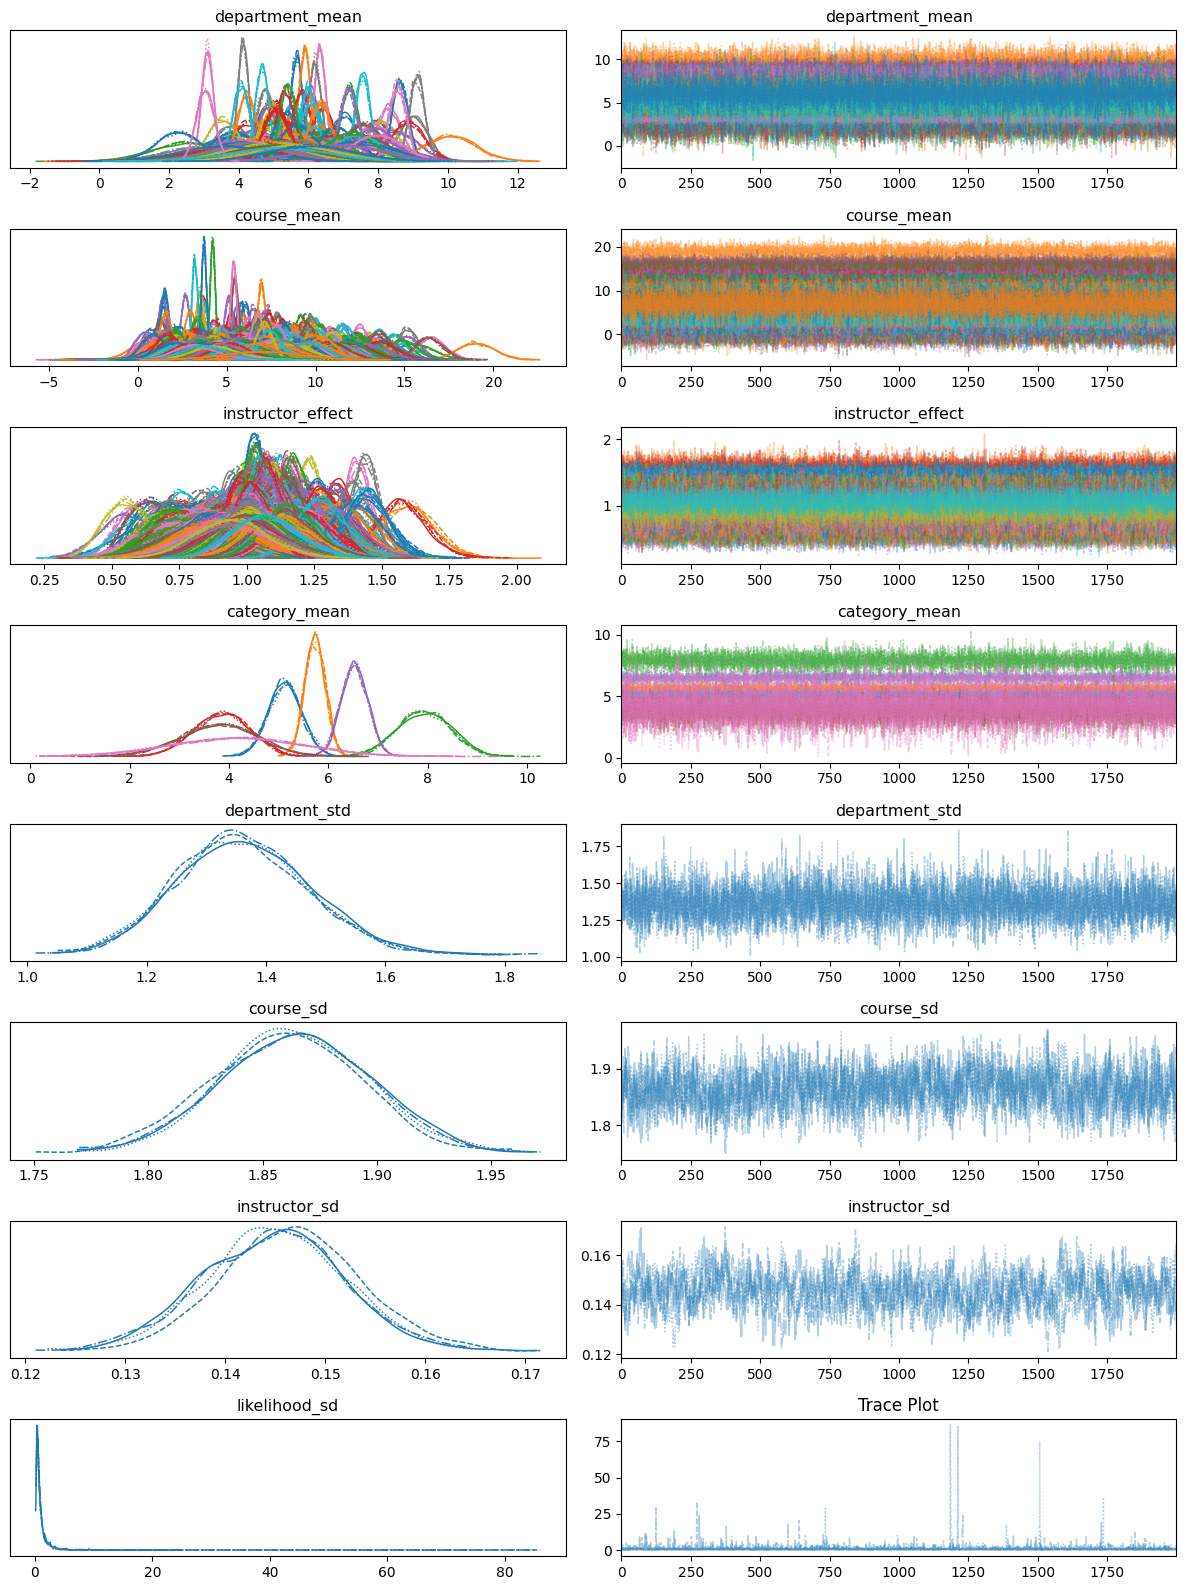

In [25]:
# check r_hat and plot
import arviz as az
print(pm.summary(trace)['r_hat'].max())

az.plot_trace(trace)
plt.title('Trace Plot')
plt.tight_layout()
plt.show()

In [21]:
# save 500 samples of each trace
# save only by instructor name

# save distribution_samples to a pickle file

distribution_samples = {}

for i in range(len(instructor_to_ids)):
    instructor = list(instructor_to_ids.keys())[i]
    distribution_samples[instructor] = np.array(trace['posterior']['instructor_effect'][0, :500, i])

# save distribution_samples to a pickle file
import pickle

with open('qreport_app/data/instructor_distribution_samples.pkl', 'wb') as f:
    pickle.dump(distribution_samples, f)

# Image Generation

The purpose of this section is to create figures for the accompanying paper.

In [79]:
sns.set()

hex_colors = ['#003f5c',
 '#58508d',
'#bc5090',
'#ff6361',
'#ffa600']

## Introduction

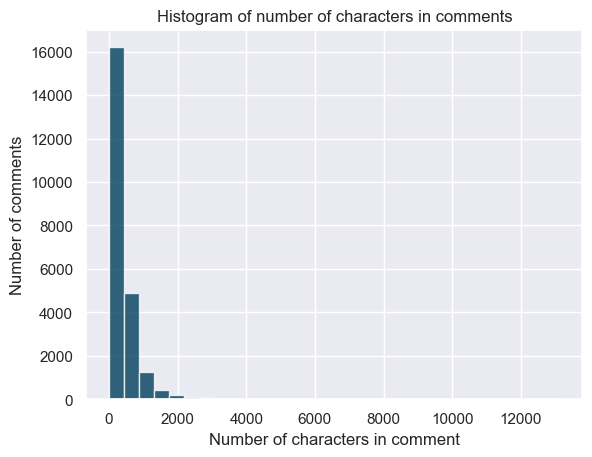

In [81]:
df_comments['comment'].str.len().hist(bins=30, alpha=0.8, color=hex_colors[0])
plt.title('Histogram of number of characters in comments')
plt.xlabel('Number of characters in comment')
plt.ylabel('Number of comments')

plt.savefig('images/INTRODUCTION_characters.png', dpi=500)

plt.show()

In [86]:
print(df_comments['comment'].str.len().describe().to_latex())

\begin{tabular}{lr}
\toprule
 & comment \\
\midrule
count & 23207.000000 \\
mean & 404.416426 \\
std & 473.773096 \\
min & 1.000000 \\
25% & 144.000000 \\
50% & 280.000000 \\
75% & 498.000000 \\
max & 13131.000000 \\
\bottomrule
\end{tabular}



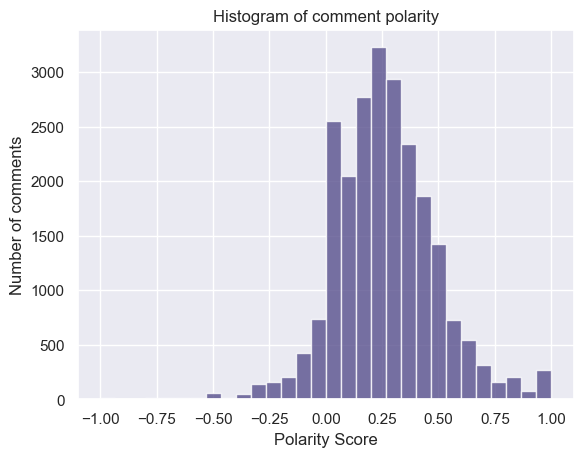

In [88]:
df_comments['sentiment'].hist(bins=30, alpha=0.8, color=hex_colors[1])
plt.title('Histogram of comment polarity')
plt.xlabel('Polarity Score')
plt.ylabel('Number of comments')

plt.savefig('images/INTRODUCTION_polarity.png', dpi=500)

plt.show()

In [90]:
print(df_comments['sentiment'].describe().to_latex())

\begin{tabular}{lr}
\toprule
 & sentiment \\
\midrule
count & 23271.000000 \\
mean & 0.257835 \\
std & 0.228954 \\
min & -1.000000 \\
25% & 0.113895 \\
50% & 0.250000 \\
75% & 0.387500 \\
max & 1.000000 \\
\bottomrule
\end{tabular}



In [92]:
df.columns

Index(['department', 'class_number', 'semester', 'year', 'name', 'link',
       'hours', 'students', 'recommendations', 'instructor_rating', 'comments',
       'number_of_comments', 'instructor', 'avg_sentiment',
       'avg_sentiment_error', 'standardized_sentiment', 'frac_stars',
       'frac_gems', 'gem_classifiers', 'pros', 'cons', 'feedback', 'category',
       'gem_index'],
      dtype='object')

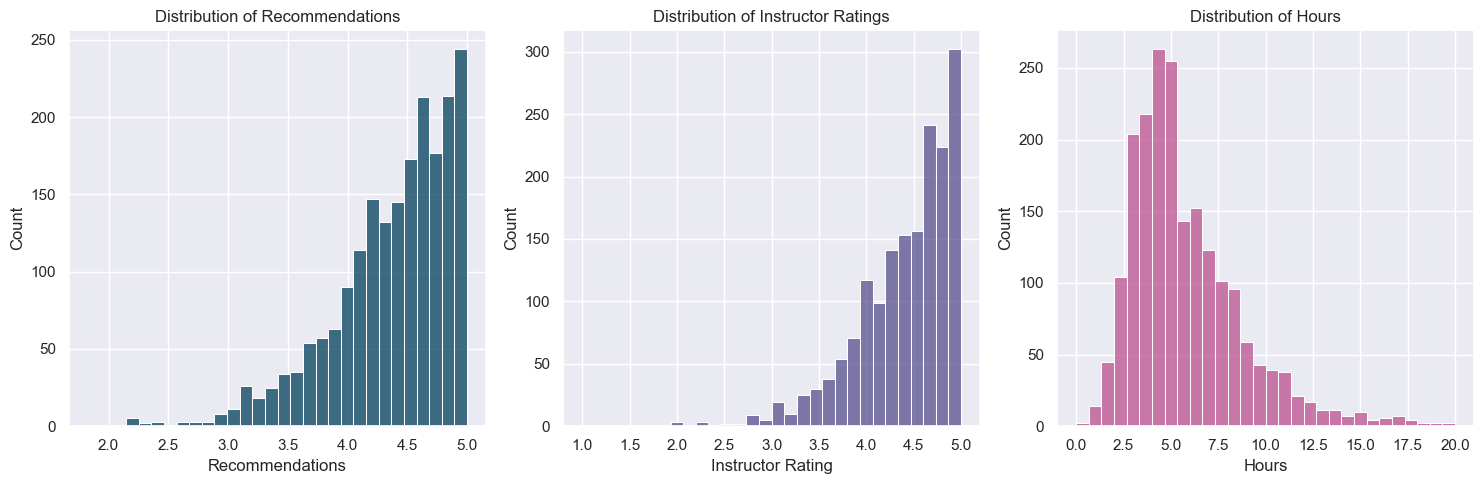

In [100]:
df[['recommendations', 'instructor_rating', 'hours']]

# create a 3,1 grid of subplots

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot the distribution of recommendations
sns.histplot(df['recommendations'], bins=30, ax=axs[0], color=hex_colors[0])
axs[0].set_title('Distribution of Recommendations')
axs[0].set_xlabel('Recommendations')

# plot the distribution of instructor ratings
sns.histplot(df['instructor_rating'], bins=30, ax=axs[1], color=hex_colors[1])
axs[1].set_title('Distribution of Instructor Ratings')
axs[1].set_xlabel('Instructor Rating')

# plot the distribution of hours
sns.histplot(df['hours'], bins=30, ax=axs[2], color=hex_colors[2])
axs[2].set_title('Distribution of Hours')
axs[2].set_xlabel('Hours')

plt.tight_layout()

plt.savefig('images/INTRODUCTION_recommendations_instructor_rating_hours.png', dpi=500)

plt.show()

In [101]:
df['department'].value_counts()

department
GOV         111
ECON        105
ENGLISH      86
FYSEMR       83
GENED        79
           ... 
SCIENCE       1
SCAND         1
SAS           1
JAPNHIST      1
SWEDISH       1
Name: count, Length: 135, dtype: int64